In [70]:
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import pickle as pk
import matplotlib.pyplot as plt
import copy

In [71]:
df_seq_hit = pd.read_csv("orthologs-human-2-yeast.tsv", sep = "\t", header = 0)
df_seq_hit["Yeast-EnsemblGeneID"] = "4932." + df_seq_hit["Yeast-EnsemblGeneID"]
df_seq_hit["EnsemblPeptide-Human"] = "9606." + df_seq_hit["EnsemblPeptide-Human"]

In [72]:
df_seq_hit

,ExternalName-Yeast,Yeast-EnsemblGeneID,Yeast-SGD,EnsemblPeptide-Human,ExternalName-Human
0,ATP6,4932.Q0085,S000007268,9606.ENSP00000354632,MT-ATP6
1,BI4,4932.Q0120,S000007273,9606.ENSP00000354554,MT-CYB
2,COX3,4932.Q0275,S000007283,9606.ENSP00000354982,MT-CO3
3,BI3,4932.Q0115,S000007272,9606.ENSP00000354554,MT-CYB
4,BI2,4932.Q0110,S000007271,9606.ENSP00000354554,MT-CYB
...,...,...,...,...,...
48208,YCK1,4932.YHR135C,S000001177,9606.ENSP00000269361,CSNK1D
48209,YCK1,4932.YHR135C,S000001177,9606.ENSP00000385769,CSNK1D
48210,YCK1,4932.YHR135C,S000001177,9606.ENSP00000463757,CSNK1D
48211,YCK1,4932.YHR135C,S000001177,9606.ENSP00000464551,CSNK1D


In [73]:
def lexical_pair(x,y):
    if x<y:
        return (x,y)
    else:
        return (y,x)

In [74]:
pair_directory = "/afs/csail.mit.edu/u/s/samsl/Work/TT3D/FoldSeek_BriefCommunication/data/pairs"
human_training = pd.read_csv(f"{pair_directory}/human_train.tsv", sep = "\t", header = None)
yeast_test = pd.read_csv(f"{pair_directory}/yeast_test.tsv", sep = "\t", header = None)

human_edge_lookup = {}
for _, r in tqdm(human_training.iterrows(), total = len(human_training)):
    human_edge_lookup[lexical_pair(r[0],r[1])] = r[2]

  0%|          | 0/421792 [00:00<?, ?it/s]

In [75]:
human_pos = human_training[human_training[2] == 1]

In [76]:
human_proteins = set(human_training[0]).union(human_training[1])

In [77]:
human_to_yeast_lookup = {}
for hp in tqdm(list(human_proteins)):
     human_to_yeast_lookup[hp] = df_seq_hit[df_seq_hit["EnsemblPeptide-Human"] == hp]["Yeast-EnsemblGeneID"].values

  0%|          | 0/15816 [00:00<?, ?it/s]

In [10]:
df_struct_hit = pd.read_csv("structure_homology/yeast_against_human_foldseek_mmseqs.tsv", sep = "\t", header = None)
thresh = 1e-10
df_struct_thresh = df_struct_hit[df_struct_hit[10] < thresh]

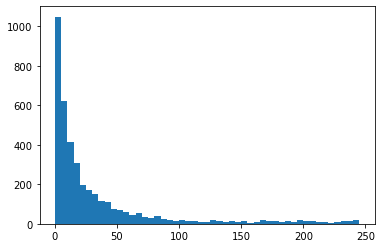

In [11]:
plt.hist(df_struct_thresh[1].value_counts().values,bins=np.arange(0,250,5))
plt.show()

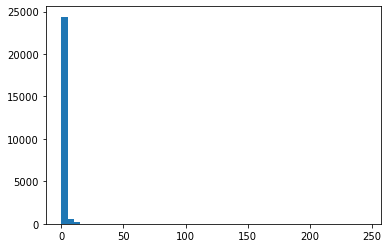

In [12]:
plt.hist(df_seq_hit["EnsemblPeptide-Human"].value_counts().values,bins=np.arange(0,250,5))
plt.show()

In [13]:
yeast_struct_lookup = {}
for hp in tqdm(list(human_proteins)):
     yeast_struct_lookup[hp] = df_struct_thresh[df_struct_thresh[0] == hp][1].values

  0%|          | 0/15816 [00:00<?, ?it/s]

In [80]:
human_training = pd.read_csv(f"{pair_directory}/human_train.tsv", sep = "\t", header = None)
yeast_test = pd.read_csv(f"{pair_directory}/yeast_test.tsv", sep = "\t", header = None)

In [83]:
yeast_proteins = list(set(yeast_test[0]).union(yeast_test[1]))

In [84]:
yeast_to_human_lookup = {}
for yp in tqdm(list(yeast_proteins)):
     yeast_to_human_lookup[yp] = df_seq_hit[df_seq_hit["Yeast-EnsemblGeneID"] == yp]["EnsemblPeptide-Human"].values

  0%|          | 0/5664 [00:00<?, ?it/s]

In [14]:
# import pickle as pk

# with open("sequence_human_to_yeast_map.pk","wb") as f:
#     pk.dump(human_to_yeast_lookup, f)
    
# with open("structure_human_to_yeast_map.pk","wb") as f:
#     pk.dump(yeast_struct_lookup, f)

In [93]:
import pickle as pk

with open("sequence_human_to_yeast_map.pk","rb") as f:
    human_to_yeast_lookup = pk.load(f)
    
with open("structure_human_to_yeast_map.pk","rb") as f:
    yeast_struct_lookup = pk.load(f)

In [94]:
human_edge_lookup = {}
for _, r in tqdm(human_training.iterrows(), total = len(human_training)):
    human_edge_lookup[lexical_pair(r[0],r[1])] = r[2]

  0%|          | 0/421792 [00:00<?, ?it/s]

In [95]:
def checknan(x):
    try:
        return np.isnan(x)
    except TypeError:
        return False

In [86]:
from itertools import product

# one to many
one_to_many_predictions = []

for _, r in tqdm(yeast_test.iterrows(), total = len(yeast_test)):
    y0, y1, true_label = r[0], r[1], r[2]
        
    y0_hits = yeast_to_human_lookup[y0]
    y1_hits = yeast_to_human_lookup[y1]
    
    pred_label = 0
    for (h0,h1) in product(y0_hits,y1_hits):
        try:
            if checknan(h0) or checknan(h1):
                continue
            human_label = human_edge_lookup[lexical_pair(h0,h1)]
            if human_label == 1:
                pred_label = 1
                break
        except KeyError:
            continue
    one_to_many_predictions.append([y0,y1,true_label,pred_label])

  0%|          | 0/55000 [00:00<?, ?it/s]

In [87]:
from sklearn.metrics import precision_score, recall_score

tp = 0
fp = 0
tn = 0
fn = 0

for (f0, f1, tl, pl) in tqdm(one_to_many_predictions):
    if tl == 1:
        if pl == 1:
            tp += 1
        elif pl == 0:
            fn += 1
    elif tl == 0:
        if pl == 1:
            fp += 1
        elif pl == 0:
            tn += 1

# Precision: tp/tp+fp;   Recall: tp/tp+fn
print(f"Precision: {tp/(tp+fp)}, Recall: {tp/(tp+fn)}")

  0%|          | 0/55000 [00:00<?, ?it/s]

Precision: 0.96875, Recall: 0.1922


In [96]:
from itertools import product
yeast_expanded = []

for _, r in tqdm(human_pos.iterrows(), total=len(human_pos)):
    p1 = r[0]
    p2 = r[1]
    p1_hits = human_to_yeast_lookup[p1]
    p2_hits = human_to_yeast_lookup[p2]
    for f1,f2 in product(p1_hits,p2_hits):
        yeast_expanded.append(lexical_pair(f1,f2))
yeast_expanded = pd.DataFrame(yeast_expanded)

  0%|          | 0/38344 [00:00<?, ?it/s]

In [97]:
from itertools import product
yeast_expanded_struct = []

for _, r in tqdm(human_pos.iterrows(), total=len(human_pos)):
    p1 = r[0]
    p2 = r[1]
    p1_hits = yeast_struct_lookup[p1]
    p2_hits = yeast_struct_lookup[p2]
    for f1,f2 in product(p1_hits,p2_hits):
        yeast_expanded_struct.append(lexical_pair(f1,f2))
yeast_expanded_struct = pd.DataFrame(yeast_expanded_struct)

  0%|          | 0/38344 [00:00<?, ?it/s]

In [98]:
yeast_expanded_dd = yeast_expanded.drop_duplicates()
yeast_expanded_struct_dd = yeast_expanded_struct.drop_duplicates()

In [99]:
len(yeast_expanded_dd)

15204

In [100]:
len(yeast_expanded_struct_dd)

1315672

In [101]:
def lexical_fix(df,ncol1 = "protein1", ncol2 = "protein2", rest_cols = ["sequence1", "sequence2"]):
    newdf = []
    for _,r in tqdm(df.iterrows(),total=len(df)):
        p1 = r[ncol1]
        p2 = r[ncol2]
        rest = r[rest_cols]
        pair = lexical_pair(p1,p2)
        newdf.append([*pair, *rest])
    df = pd.DataFrame(newdf)
    df.columns = [ncol1, ncol2, *rest_cols]
    return df

In [102]:
full_true_yeast_net = pd.read_csv("yeast_full_32k.tsv",sep="\t",header=0)
# tt3d_full_yeast_net = pd.read_csv("full_fly_tt3d_out.tsv",sep="\t",header=None)
full_true_fly_net = lexical_fix(full_true_yeast_net)

  0%|          | 0/31926 [00:00<?, ?it/s]

In [103]:
full_true_yeast_net

,protein1,protein2,sequence1,sequence2
0,4932.Q0045,4932.Q0105,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...,MAFRKSNVYLSLVNSYIIDSPQPSSINYWWNMGSLLGLCLVIQIVT...
1,4932.Q0045,4932.Q0250,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...,MLDLLRLQLTTFIMNDVPTPYACYFQDSATPNQEGILELHDNIMFY...
2,4932.Q0045,4932.Q0275,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...,MTHLERSRHQQHPFHMVMPSPWPIVVSFALLSLALSTALTMHGYIG...
3,4932.Q0045,4932.YBL045C,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...,MLRTVTSKTVSNQFKRSLATAVATPKAEVTQLSNGIVVATEHNPSA...
4,4932.Q0045,4932.YDL067C,MVQRWLYSTNAKDIAVLYFMLAIFSGMAGTAMSLIIRLELAAPGSQ...,MTIAPITGTIKRRVIMDIVLGFSLGGVMASYWWWGFHMDKINKREK...
...,...,...,...,...
31921,4932.YPR144C,4932.YPR163C,MVLLISEIKDIAKRLTAAGDRKQYNSIIKLINELVIPENVTQLEED...,MAPPKKTVKKMDLTSFLNDDTFGSSWAEEDVDLNKITIPIETANAN...
31922,4932.YPR161C,4932.YPR171W,MSDNGSPAVLPKTEFNKYKIGKVKSTPAIQRDAKTNLTYIKLRKRS...,MTKYERDPELVNFLSKVEDLNSKRYSNIPSSKPAGEALSPVRSHNS...
31923,4932.YPR162C,4932.YPR175W,MTISEARLSPQVNLLPIKRHSNEEVEETAAILKKRTIDNEKCKDSD...,MFGSGNVLPVKIQPPLLRPLAYRVLSRKYGLSIKSDGLSALAEFVG...
31924,4932.YPR178W,4932.YPR182W,MSKYIALENLPVDLQHKGATQNESTADILKQLPHERLQAVLEKIPE...,MSESSDISAMQPVNPKPFLKGLVNHRVGVKLKFNSTEYRGTLVSTD...


In [104]:
full_true_yeast_net = full_true_fly_net[["protein1","protein2"]]
full_true_yeast_net.columns = [0,1]

In [105]:
import pandas as pd

In [106]:
import h5py
yeast_embeddings = h5py.File("/afs/csail/u/s/samsl/Work/databases/STRING/s.cerevisiae/yeast.h5","r")
yeast_emb_keys = list(yeast_embeddings.keys())

In [107]:
def filter_df(df, keys):
    return df[df[0].isin(keys) & df[1].isin(keys)]
    

In [108]:
yeast_expanded_dd

,0,1
0,4932.YHL002W,4932.YKL002W
1,4932.YKL002W,4932.YNR006W
2,4932.YHR108W,4932.YKL002W
3,4932.YDR358W,4932.YKL002W
4,4932.YJR050W,4932.YOR159C
...,...,...
18963,4932.YCL031C,4932.YML093W
18964,4932.YDR330W,4932.YLL039C
18965,4932.YER094C,4932.YGL011C
18966,4932.YDR225W,4932.YER179W


In [109]:
sequence_f0_fstar = filter_df(pd.concat([yeast_expanded_dd, full_true_yeast_net]).drop_duplicates(), yeast_emb_keys)
struct_f0_fstar = filter_df(pd.concat([yeast_expanded_struct_dd, full_true_yeast_net]).drop_duplicates(), yeast_emb_keys)

In [29]:
# sequence_f0_fstar.to_csv("yeast_sequence_f0_fstar.tsv",sep="\t",header=None,index=False)
# struct_f0_fstar.to_csv("yeast_structure_f0_fstar.tsv",sep="\t",header=None,index=False)

In [30]:
# sequence_f0_fstar.to_csv("sequence_f0_fstar.tsv",sep="\t",header=None,index=False)
# struct_f0_fstar.to_csv("structure_f0_fstar.tsv",sep="\t",header=None,index=False)

In [110]:
sequence_f0_fstar = pd.read_csv("yeast_sequence_f0_fstar.tsv",sep="\t",header=None)
struct_f0_fstar = pd.read_csv("yeast_structure_f0_fstar.tsv",sep="\t",header=None)

In [111]:
sequence_f0_fstar = filter_df(sequence_f0_fstar, yeast_emb_keys)
struct_f0_fstar = filter_df(struct_f0_fstar, yeast_emb_keys)

In [112]:
len(sequence_f0_fstar)

40063

In [113]:
len(struct_f0_fstar)

1330368

In [114]:
fstar = full_true_yeast_net
seq_f0 = yeast_expanded_dd
struct_f0 = yeast_expanded_struct_dd

In [115]:
seq_tp = pd.merge(fstar, seq_f0, how="inner").shape[0]
seq_precision = seq_tp / len(seq_f0)
seq_recall = seq_tp / len(fstar)
print(seq_precision, seq_recall)

0.40252565114443567 0.19169329073482427


In [116]:
struct_tp = pd.merge(fstar, struct_f0, how="inner").shape[0]
struct_precision = struct_tp / len(struct_f0)
struct_recall = struct_tp / len(fstar)
print(struct_precision, struct_recall)

0.013095969208130902 0.5396855227714089


In [117]:
tt3d_yeast_sequence_f0_fstar_all = pd.read_csv("~/Work/TT3D/FoldSeek_BriefCommunication/yeast_sequence_f0_fstar_out.tsv",sep="\t",header=None)
tt3d_structure_f0_fstar_all = pd.read_csv("~/Work/TT3D/FoldSeek_BriefCommunication/yeast_structure_f0_fstar_out.tsv",sep="\t",header=None)

In [118]:
sequence_f0_fstar

,0,1
0,4932.YHL002W,4932.YKL002W
1,4932.YKL002W,4932.YNR006W
2,4932.YHR108W,4932.YKL002W
3,4932.YDR358W,4932.YKL002W
4,4932.YJR050W,4932.YOR159C
...,...,...
40058,4932.YPR144C,4932.YPR163C
40059,4932.YPR161C,4932.YPR171W
40060,4932.YPR162C,4932.YPR175W
40061,4932.YPR178W,4932.YPR182W


In [119]:
import copy
fstar_labeled = copy.deepcopy(fstar)
fstar_labeled[2] = 1

In [120]:
from sklearn.metrics import average_precision_score, precision_recall_curve


In [121]:
fstar_labeled

,0,1,2
0,4932.Q0045,4932.Q0105,1
1,4932.Q0045,4932.Q0250,1
2,4932.Q0045,4932.Q0275,1
3,4932.Q0045,4932.YBL045C,1
4,4932.Q0045,4932.YDL067C,1
...,...,...,...
31921,4932.YPR144C,4932.YPR163C,1
31922,4932.YPR161C,4932.YPR171W,1
31923,4932.YPR162C,4932.YPR175W,1
31924,4932.YPR178W,4932.YPR182W,1


In [122]:
tt3d_yeast_sequence_f0_fstar_all

,0,1,2
0,4932.YHL002W,4932.YKL002W,0.023187
1,4932.YKL002W,4932.YNR006W,0.013596
2,4932.YHR108W,4932.YKL002W,0.909159
3,4932.YDR358W,4932.YKL002W,0.891827
4,4932.YJR050W,4932.YOR159C,0.210315
...,...,...,...
40058,4932.YPR144C,4932.YPR163C,0.013097
40059,4932.YPR161C,4932.YPR171W,0.015162
40060,4932.YPR162C,4932.YPR175W,0.032388
40061,4932.YPR178W,4932.YPR182W,0.358344


In [125]:
pr[np.argwhere((re > 0.1917))], re[np.argwhere((re > 0.1917))]

(array([[0.79689489],
        [0.79688943],
        [0.79724228],
        ...,
        [0.69139566],
        [0.69136081],
        [0.69132595]]),
 array([[1.        ],
        [0.99984339],
        [0.99968678],
        ...,
        [0.19178726],
        [0.19175594],
        [0.19172461]]))

aupr: 0.7408774782286006


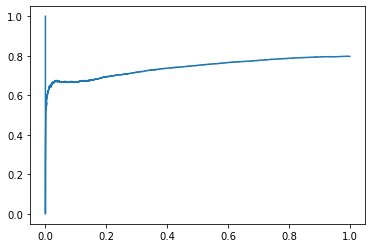

In [126]:
seq_merged_df = pd.merge(tt3d_yeast_sequence_f0_fstar_all, fstar_labeled, left_on=[0,1], right_on=[0,1],how="outer").fillna(0)
print(f'aupr: {average_precision_score(seq_merged_df["2_y"], seq_merged_df["2_x"])}')
pr, re, th = precision_recall_curve(seq_merged_df["2_y"], seq_merged_df["2_x"])
plt.plot(re,pr)
plt.show()

aupr: 0.12259221651919601


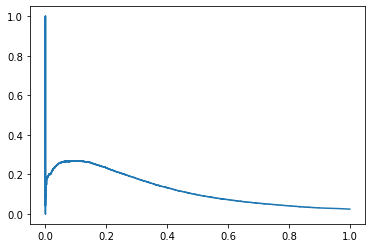

In [127]:
struct_merged_df = pd.merge(tt3d_structure_f0_fstar_all, fstar_labeled, left_on=[0,1], right_on=[0,1],how="outer").fillna(0)
print(f'aupr: {average_precision_score(struct_merged_df["2_y"], struct_merged_df["2_x"])}')
pr, re, th = precision_recall_curve(struct_merged_df["2_y"], struct_merged_df["2_x"])
plt.plot(re,pr)
plt.show()

In [129]:
pr[np.argwhere((re > 0.5397))], re[np.argwhere((re > 0.5397))]

(array([[0.02399787],
        [0.02399798],
        [0.0240012 ],
        ...,
        [0.08565478],
        [0.0856552 ],
        [0.08565563]]),
 array([[1.        ],
        [1.        ],
        [0.99984339],
        ...,
        [0.53971685],
        [0.53971685],
        [0.53971685]]))

aupr: 0.12259221651919601


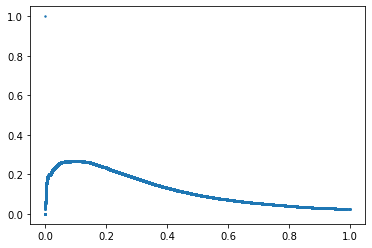

In [130]:
print(f'aupr: {average_precision_score(struct_merged_df["2_y"], struct_merged_df["2_x"])}')
plt.scatter(re,pr,s=2)
plt.show()